In [3]:
# basic plotting imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

# import h5py

import numpy as np
import pandas as pd

from neurodsp import spectral
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})
sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})

#### Data source

These data are the [PVC-6 data from CRCNS](https://crcns.org/data-sets/vc/pvc-6/about_pvc-6). From their summary:

>The data sets consist of whole cell current clamp slice electrophysiology recordings made from single neurons from coronal sections of the visual cortex of adult male mice. The experiments were performed in the presence of blockers of fast synaptic transmission with the goal of understanding the diversity of intrinsic neuronal excitability between cell classes. These experiments represent preliminary datasets being used to refine methods working towards producing slice electrophysiology data at scale.

These data are ideal for several reasons. First, and most critical for us, is that they're sampled at 200,000 Hz! So if we want to parameterize individual action potentials, for a 1ms AP we'll have 200 data points. This is much more approachable than the 20-40 datapoints that have been limiting us on the other datsets.

Second, these are intracellular patch clamp recordings, so they're not susceptible to our concern that extracellular AP shapes are affected by the position of the electrode relative to the neuron, which is not necessaily stable over time (meaning that any observed AP shape differences could theoretically be driven by movement rather than physiology).

Finally, these neurons were driven by 1/f pink noise, which we like a lot. The variability of the 1/f exponent over time will allow us to link stimulus parameters to any variation in AP shape parameters.

In [2]:
# open and load the data

fs = 200000 # sampling rate
one_ms = int(fs / 1000)

# 153098_04_02_data has 0 through 66 sweeps
# 151145_04_Data  has 0 through 91 sweeps
filename = 'pvc-6/153098_04_02_data.h5' # filename

# open file
f = h5py.File(filename, 'r')

# list(f.keys())

# qc_data = f['qcSweep_Key']
# qc_data[0, :, :]

In [3]:
# helper functions

# load sweeps
def load_sweep(sweep_number):
    # load sweep
    dset = f['Sweep_' + str(sweep_number)]

    # create array of time indices
    convert_to_ms = (fs / 1000)
    times = np.arange(0, np.shape(dset)[0]) / convert_to_ms # in ms instead of sec

    return dset, times

# get the power spectrum of the stimulus
def get_stim_spectrum(dset, fs, nperseg):
    stim_data = dset[:, 1]
    fxx, pxx = spectral.compute_spectrum(stim_data, fs, method='welch',
                window='hann', nperseg=nperseg)
    return fxx, pxx

# plot the ephys data
def plot_ephys_data(dset, times, index_start, index_end):
    plot_range = (index_start, index_end)
    plt.plot(times[plot_range[0]:plot_range[1]],
        dset[plot_range[0]:plot_range[1], 1], '.')

# plot the stimulus
def plot_stim_data(dset, times, index_start, index_end):
    plot_range = (index_start, index_end)
    plt.plot(times[plot_range[0]:plot_range[1]],
        dset[plot_range[0]:plot_range[1], 0], '.')

# plot the stimulus spectrum
def plot_stim_spectrum(fxx, pxx, xlim, ylim):
    plt.loglog(fxx, pxx)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (V^2/Hz)')
    plt.xlim(xlim)
    plt.ylim(ylim)

# find the spike times
def find_spike_times(data, thresh_mv, thresh_ms):
    # thresh_mv is the voltage threshold that needs to be crossed
    # thresh_ms is how many ms each peak needs to be from the next

    peaks = find_peaks(data, height=thresh_mv, distance=thresh_ms)
    idx_spikes = peaks[0] # spike indices
    amp_spikes = peaks[1]['peak_heights'] # spike amplitudes

    return idx_spikes, amp_spikes

# define exponential function
def exp_func(times, exp_amp, exp_lambda, exp_timeshift, exp_const):
    return exp_amp * np.exp(-exp_lambda * (times - exp_timeshift)) + exp_const

# fit exponential data
def fit_exp_nonlinear(times, data, initial_guesses, bounds):
    popt, _ = curve_fit(exp_func, times, data, p0=initial_guesses, bounds=bounds,  maxfev=10000)
    exp_amp, exp_lambda, exp_timeshift, exp_const = popt
    return exp_amp, exp_lambda, exp_timeshift, exp_const

#### Constant current

Some of the sweeps are driven by a constant current, as can be seen below. For now we'll ignore these, but in theory, depending on the stimulus parameters, these could be used to measure any AP shape parameter adaptation over time, as well as a control to compare against 1/f pink noise stimulation.

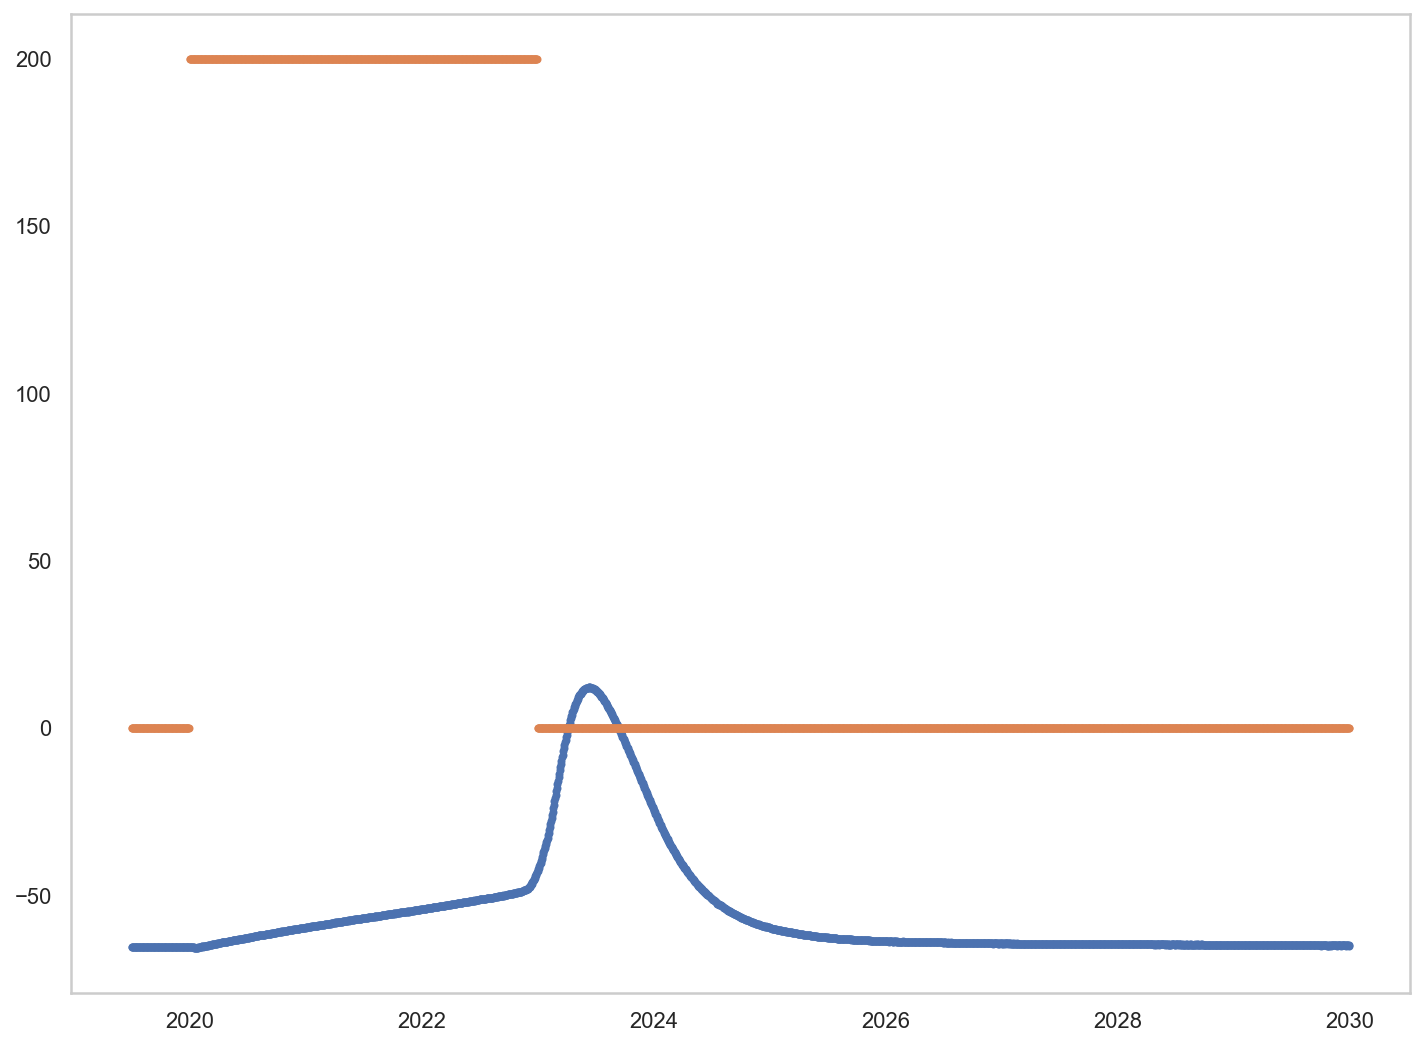

In [4]:
sweep_number = 3
index_start = 403900
index_end = 406000

dset, times = load_sweep(sweep_number)
plot_ephys_data(dset, times, index_start, index_end)
plot_stim_data(dset, times, index_start, index_end)
plt.show()

#### Pink noise (1/f) stimulation

Many of the sweeps are drive by pink noise, and we can leverage the variability in this stimulus to examine the link between variations in the stimulus and AP shape parameters.

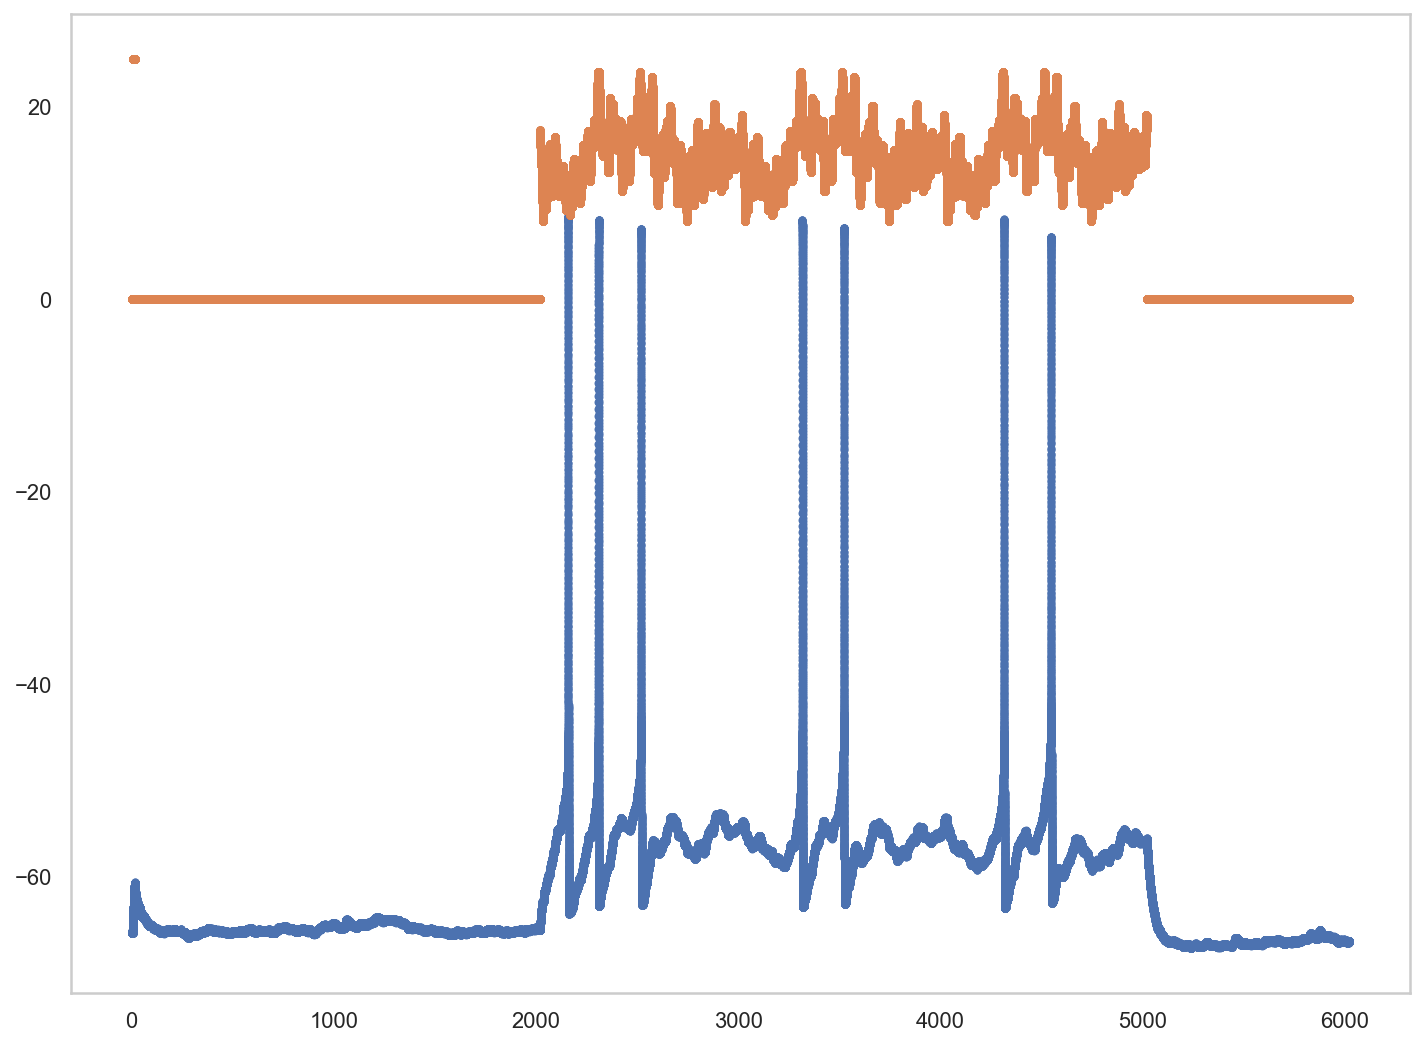

In [5]:
sweep_number = 14
index_start = 0
index_end = int(10e10)

dset, times = load_sweep(sweep_number)
plot_ephys_data(dset, times, index_start, index_end)
plot_stim_data(dset, times, index_start, index_end)
plt.show()

#### Pink noise stimulus spectrum

You can see below that the stimulus is only 1/f in the range of ~[10, 200], so for future 1/f paramterization, we'll fit a linear regression to the loglog spectrum on that range, if the time windows are sufficient.

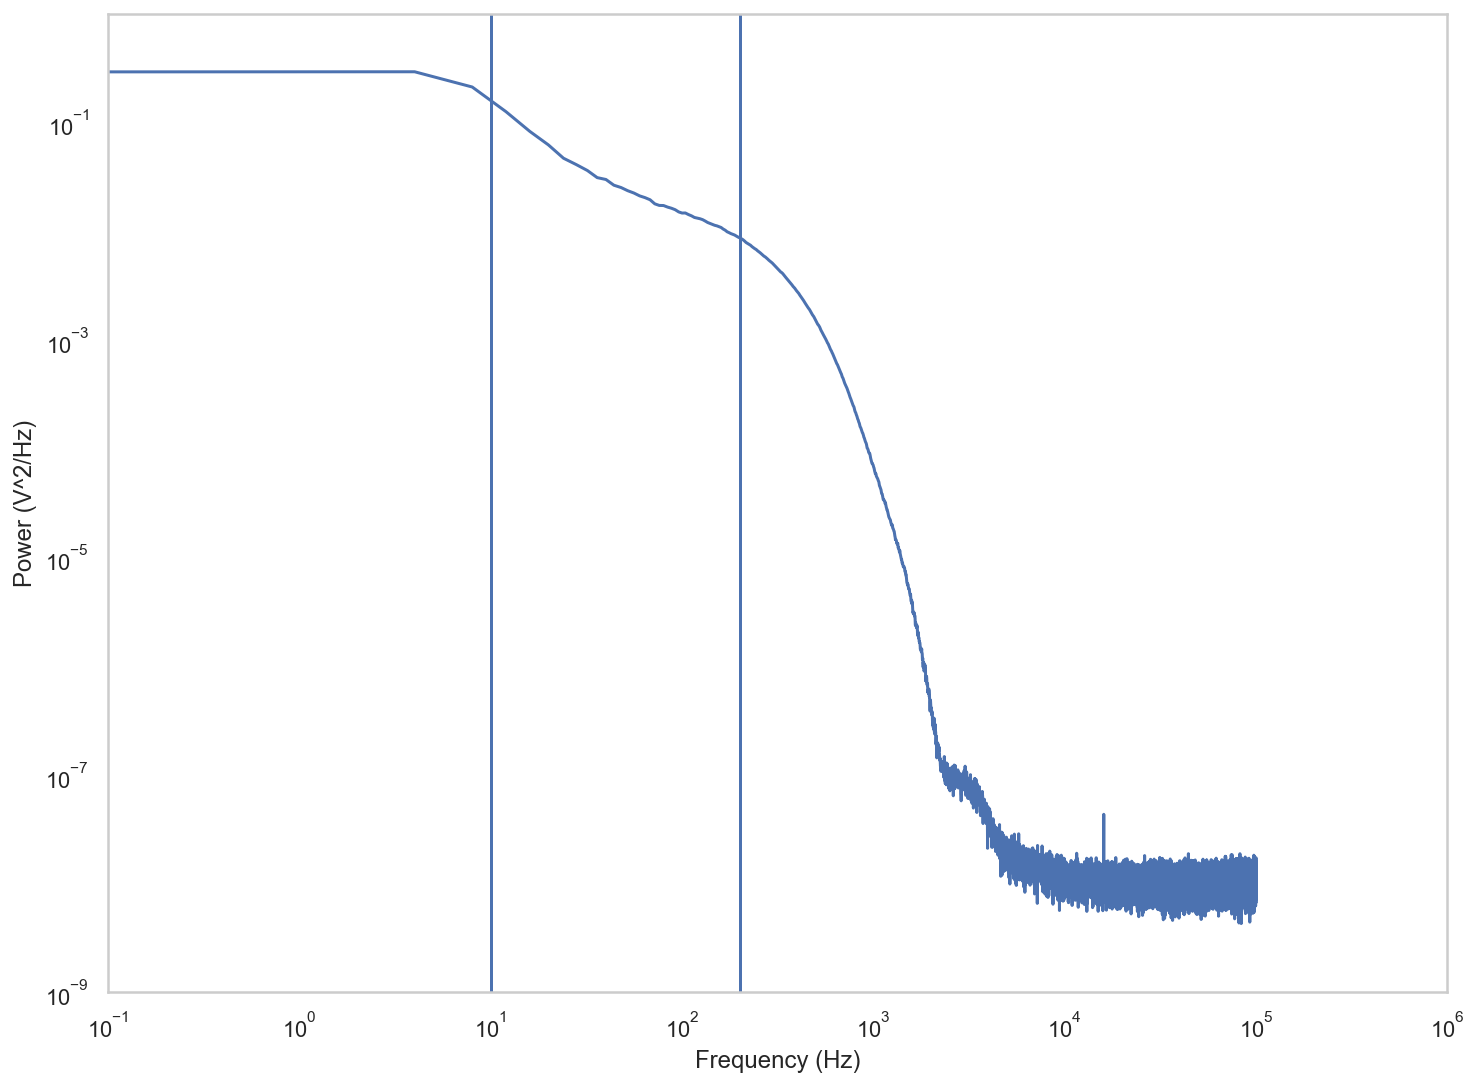

In [6]:
xlim = (10e-2, 10e5)
ylim = (10e-10, 10e-1)

fxx, pxx = get_stim_spectrum(dset, fs, nperseg=fs/4)
plot_stim_spectrum(fxx, pxx, xlim, ylim)
plt.axvline(x=10)
plt.axvline(x=200)
plt.show()

#### Process the data!

The pink noise sweeps all begin with a brief (sub-threshold, always?) stimulus, and then the pink noise stimulus that evokes APs. I use a simple peak-finding approach to find all APs, and then extract time windows around those APs for parameterization of both the APs and the stimulus.

In order to find the inflection point where the AP "starts", we take the difference (~derivative) of the intracellular data around the spike, and find the point where that derivative rises above the noise. This differenced time series is smoothed using simple lowess smoothing, to make things easier.

One cool thing to note here is how similar to an extracelluar AP this derivative of the intracellular AP looks! This probably isn't a coincidence, and has been remarked upon for a very long time. It's worth considering in our future analyses.

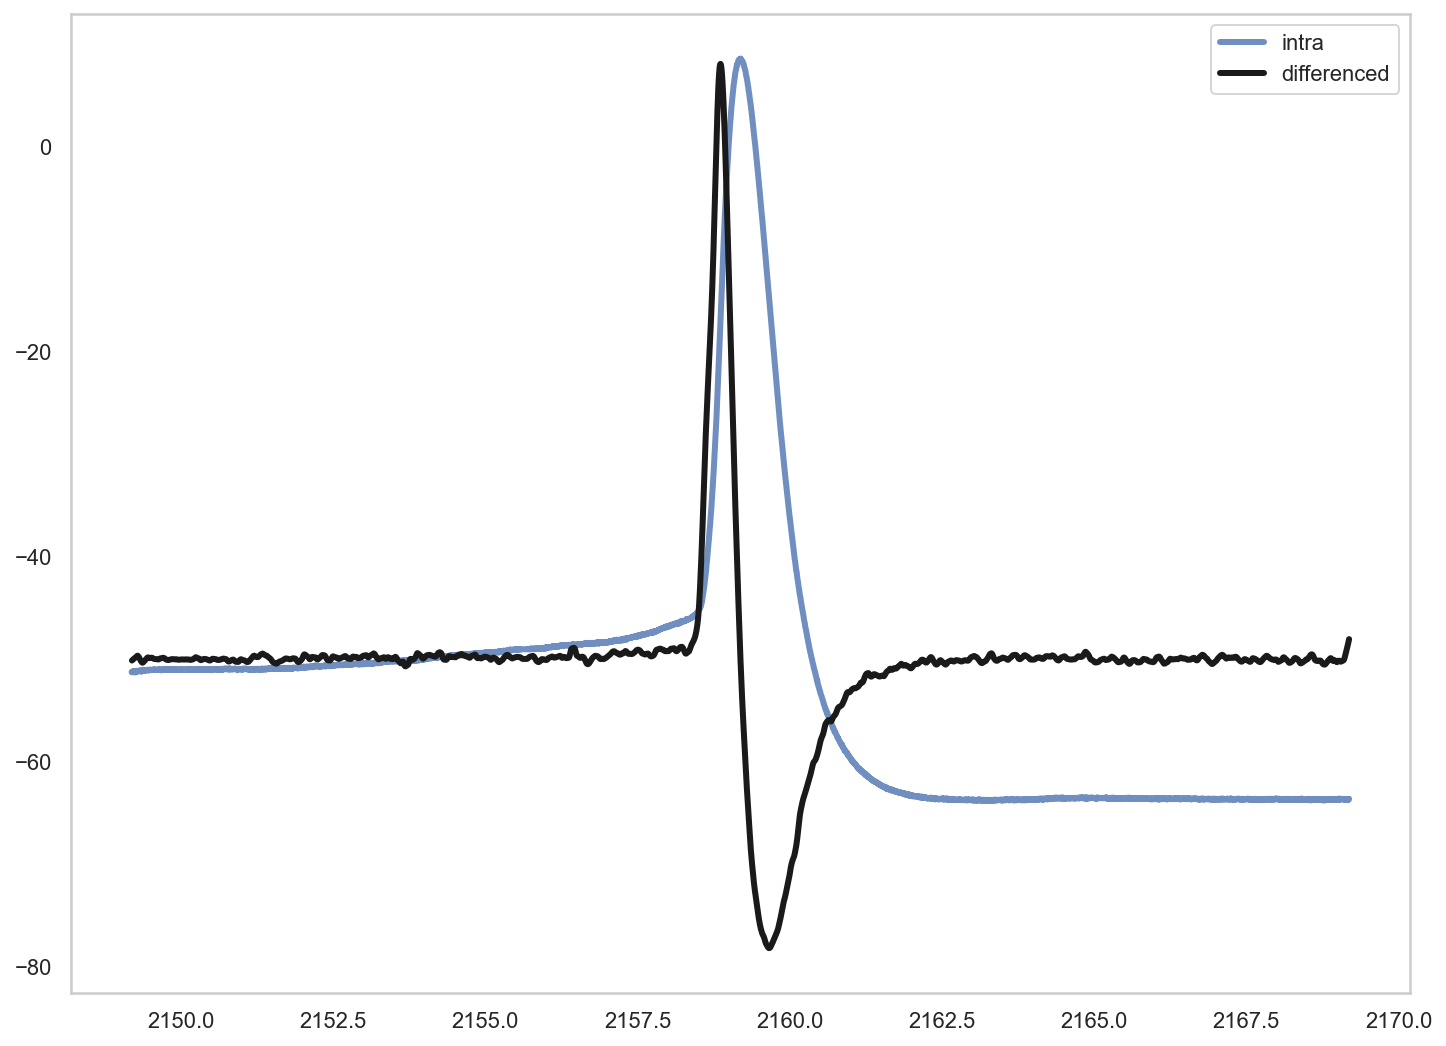

In [7]:
# Plot single spike, and its derivative
i_sweeps = 14

dset, times = load_sweep(i_sweeps)

stim = dset[:, 0] # current injection
data = dset[:, 1] # ephys data

#########################
# find spikes
thresh_mv = -10
thresh_ms = one_ms * 1 # 1 ms

idx_spikes, amp_spikes = find_spike_times(data, thresh_mv, thresh_ms)

#########################
i_spikes = 0
    
# get windows around spikes
# create window indices
window_length = (10, 10) # in ms
window_pre = int(one_ms * window_length[0])
window_post = int(one_ms * window_length[1])

# get window
window_spike_pre = (idx_spikes[i_spikes]-window_pre)
window_spike_post = (idx_spikes[i_spikes]+window_post)

# get window for times as well
windowed_times = times[(idx_spikes[i_spikes]-window_pre):
                    (idx_spikes[i_spikes]+window_post)]

# get data window
windowed_data = data[window_spike_pre:window_spike_post]

# difference of data, and smooth it
d_windowed_data = np.diff(windowed_data)
smoothed_data = sm.nonparametric.lowess(d_windowed_data, windowed_times[1:], frac=0.008)

# smoothed data
d_smoothed_times = smoothed_data[:, 0]
d_smoothed_data = smoothed_data[:, 1]

plt.plot(windowed_times, windowed_data, 'b', alpha = 0.8, linewidth = 3., label='intra')
plt.plot(d_smoothed_times, (d_smoothed_data*80)-50, 'k', linewidth = 3., label='differenced')
plt.legend()
plt.show()

In [8]:
# set up data for appending, to move to df because ugh
df_sweep = []
df_stim_type = []
df_spike_number = []
df_voltage_ramp = []
df_inflection_time = []
df_inflection_mv = []
df_peak_amplitude = []
df_peak_sharpness = []
df_decay_lambda = []
df_decay_const = []
# df_spike_width = []
df_stim_exp = []
df_stim_mean = []
df_stim_std = []

# 0 through 66 sweeps
for i_sweeps in range(66):

    #load data
    dset, times = load_sweep(i_sweeps)

    stim = dset[:, 0] # current injection
    data = dset[:, 1] # ephys data

    #########################
    # find spikes
    thresh_mv = -10
    thresh_ms = one_ms * 1 # 1 ms

    idx_spikes, amp_spikes = find_spike_times(data, thresh_mv, thresh_ms)

    #########################
    # loop across spikes
    if np.size(idx_spikes) > 0:

        #########################
        # check if sweep stim is constant, ramp, or pink

        stim_data = dset[:, 0]

        # set the first 25 ms to zero to get rid of mini-pulse at beginning
        stim_data[0:5000] = 0
        stim_data = stim_data[stim_data!=0]

        if np.size(stim_data) > 2:
            # a pearson correlation between current and time is
                # nan for constant, near 1.0 for ramp, and low for pink noise
            r, _ = pearsonr(np.arange(np.size(stim_data)), stim_data)

            # check stim type
            if (np.isnan(r)):
                stim_type = 'constant'
            elif (~np.isnan(r) & (r>0.95)):
                stim_type = 'ramp'
            elif (~np.isnan(r) & (r<0.95)):
                stim_type = 'pink'
        else:
            stim_type = 'none'

        #########################
        # paramterize each spike
        for i_spikes in range(np.size(idx_spikes)):
            # get windows around spikes
            # create window indices
            window_length = (10, 10) # in ms
            window_pre = int(one_ms * window_length[0])
            window_post = int(one_ms * window_length[1])

            # get window
            window_spike_pre = (idx_spikes[i_spikes]-window_pre)
            window_spike_post = (idx_spikes[i_spikes]+window_post)

            # get window for times as well
            windowed_times = times[(idx_spikes[i_spikes]-window_pre):
                                (idx_spikes[i_spikes]+window_post)]

            # get data window
            windowed_data = data[window_spike_pre:window_spike_post]

            # difference of data, and smooth it
            d_windowed_data = np.diff(windowed_data)
            smoothed_data = sm.nonparametric.lowess(d_windowed_data, windowed_times[1:], frac=0.008)

            # smoothed data
            d_smoothed_times = smoothed_data[:, 0]
            d_smoothed_data = smoothed_data[:, 1]


            #########################
            # inflection_time
            thresh_zscore = 40 # zscore threshold for inflection point
                                # REALLY high, since it's so low noise

            # get mean and std of first ms of data
            noise_window = d_smoothed_data[0:one_ms] 
            noise_mean = np.mean(noise_window)
            noise_std = np.std(noise_window)

            # zscore spike relative to window above
            z_data = (d_smoothed_data-noise_mean) / noise_std

            # find the peak of the zscored data
            idx_z_peak, _ = find_spike_times(z_data, thresh_zscore, thresh_ms)

            # find the peak of the real data
            idx_spike_peak, _ = find_spike_times(windowed_data, thresh_mv, thresh_ms)

            # find inflection voltage and time relative to spike peak
            inflection_time = np.abs(z_data[0:idx_z_peak[0]]-thresh_zscore)
            idx_inflection = np.argmin(inflection_time)

            # get the voltage ramp slope for the 0.5 ms before inflection point
            idx_ramp_start = idx_inflection - int(0.5 * one_ms) # 0.5 ms before
            ramp_times = windowed_times[idx_ramp_start:idx_inflection]

            voltage_ramp, _ = np.polyfit(ramp_times, windowed_data[idx_ramp_start:idx_inflection], 1)

            inflection_time = idx_spike_peak - idx_inflection
            inflection_time = inflection_time[0] / one_ms

            inflection_mv = windowed_data[idx_inflection]


            #########################
            # peak voltage
            idx_spike_peak, amp_spike_peak = find_spike_times(windowed_data, thresh_mv, thresh_ms)
            mv_peak = amp_spike_peak[0]


            #########################
            # peak sharpness
                # this is just Scott's simple oscillation sharpness approach
            sharpness_peak = ((windowed_data[idx_spike_peak[0]]-windowed_data[idx_spike_peak[0]-5]) + 
            (windowed_data[idx_spike_peak[0]]-windowed_data[idx_spike_peak[0]+5])) / 2


            #########################
            # voltage decay rate and voltage floor
            decay_curve_shift = one_ms/2 # the ap peak is curved, so shift to the right to get a cleaner decay
            decay_curve_floor_time = one_ms*5 # decide when to call it the floor
            idx_spike_peak, amp_peak = find_spike_times(windowed_data, thresh_mv, thresh_ms)
            exp_window = idx_spike_peak[0]+int(decay_curve_shift) # shift to the right
            exp_window_end = exp_window+int(decay_curve_floor_time) # when to end the curve
            exp_data = windowed_data[exp_window:exp_window_end]
            exp_times = windowed_times[exp_window:exp_window_end]

            # initial guesses, derived from physiological estimating
            initial_guesses = np.array([50, 1, windowed_times[exp_window], -60], dtype=np.float64)
            bounds = ([0, 0, 0, -100], [1000, 3, 10e9, 50]) # set some reasonable bounds

            # fit the dang thing
            exp_amp, exp_lambda, exp_timeshift, exp_const = \
                fit_exp_nonlinear(exp_times, exp_data, initial_guesses, bounds)

            # # check the fit
            # fitted_model = exp_func(exp_times, exp_amp, exp_lambda, exp_timeshift, exp_const)

            # # plot it!
            # plt.plot(exp_times, exp_data, 'k')
            # plt.plot(exp_times, fitted_model, 'b')
            # plt.show()


            if stim_type == 'pink':
                #########################
                # quantify stimulus parameters

                # create window indices
                window_length = (10, 10) # in ms
                window_pre = int(one_ms * window_length[0])
                window_post = int(one_ms * window_length[1])
                
                # get the 5 ms before the inflection point
                inflection_pre_window = int(idx_inflection - (one_ms * 5))

                # get window
                window_spike_pre = (idx_spikes[i_spikes]-window_pre)
                window_spike_post = (idx_spikes[i_spikes]+window_post)

                windowed_stim = stim[window_spike_pre:window_spike_post]
                windowed_stim = windowed_stim[inflection_pre_window:idx_inflection]

                # get slope of spectrum (exponent)
                fxx, pxx = spectral.compute_spectrum(windowed_stim, fs, method='welch',
                                window='hann', nperseg=np.size(windowed_stim))

                # get rid of zero Hz
                fxx = fxx[1:]
                pxx = pxx[1:]

                stim_exp, _ = np.polyfit(np.log10(fxx), np.log10(pxx), 1)
                stim_exp = -stim_exp # change from slope to exponent

                # stim mean and std
                stim_mean = np.mean(windowed_stim)
                stim_std = np.std(windowed_stim)
            
            else: # not pink noise, so set stim params to nan
                stim_exp = np.nan
                stim_mean = np.nan
                stim_std = np.nan


            #########################
            # collect all the relevant features
            df_sweep.append(i_sweeps)
            df_stim_type.append(stim_type)
            df_spike_number.append(i_spikes)
            df_voltage_ramp.append(voltage_ramp)
            df_inflection_time.append(inflection_time)
            df_inflection_mv.append(inflection_mv)
            df_peak_amplitude.append(mv_peak)
            df_peak_sharpness.append(sharpness_peak)
            df_decay_lambda.append(exp_lambda)
            df_decay_const.append(exp_const)
            # df_spike_width.append(spike_width)
            df_stim_exp.append(stim_exp)
            df_stim_mean.append(stim_mean)
            df_stim_std.append(stim_std)

        # print(voltage_ramp, inflection_time, inflection_mv, mv_peak, sharpness_peak, exp_lambda, exp_const,
        #         stim_exp, stim_mean, stim_std)


/Users/voytek/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [9]:
# create df
    # stim_type = 'constant', 'ramp', 'pink'
df = pd.DataFrame({'sweep': df_sweep, 'stim_type': df_stim_type, 'spike_num': df_spike_number,
                    'voltage_ramp': df_voltage_ramp, 'inflection_time': df_inflection_time,
                    'inflection_amp': df_inflection_mv, 'peak_amp': df_peak_amplitude,
                    'peak_sharp': df_peak_sharpness, 'decay_exp': df_decay_lambda,
                    'decay_const': df_decay_const, 'stim_exp': df_stim_exp, 'stim_mean': df_stim_mean,
                    'stim_std': df_stim_std},
        columns=['sweep', 'stim_type', 'spike_num', 'voltage_ramp', 'inflection_time', 'inflection_amp',
                'peak_amp', 'peak_sharp', 'decay_exp', 'decay_const', 'stim_exp', 'stim_mean', 'stim_std'])

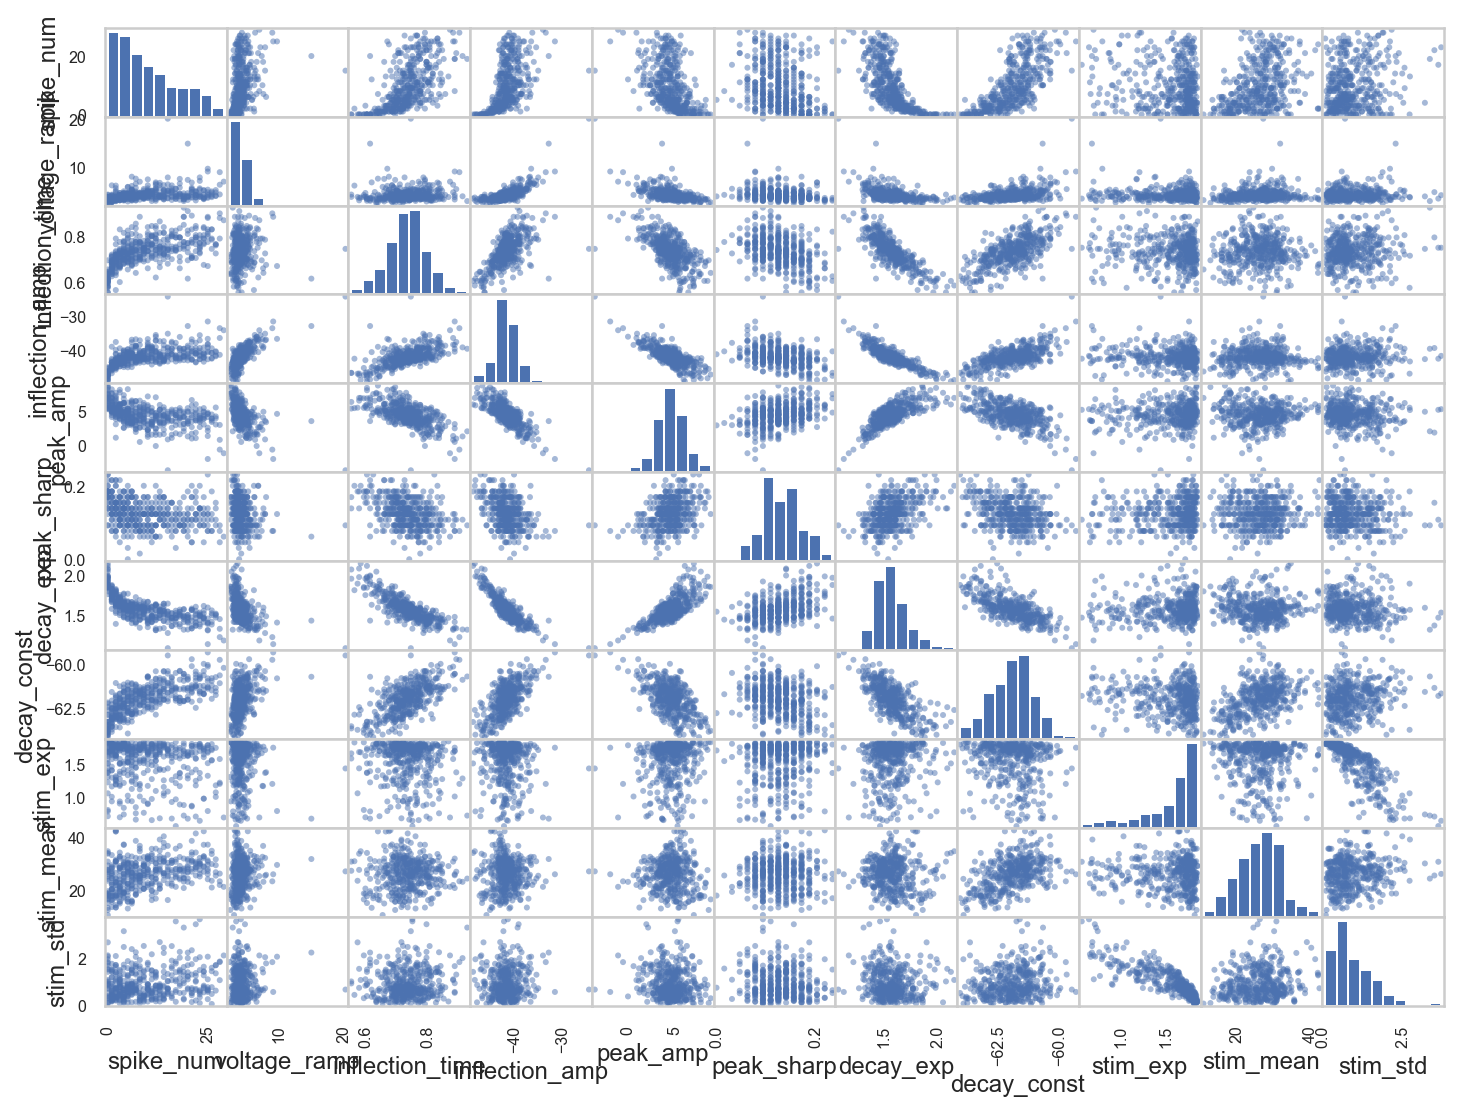

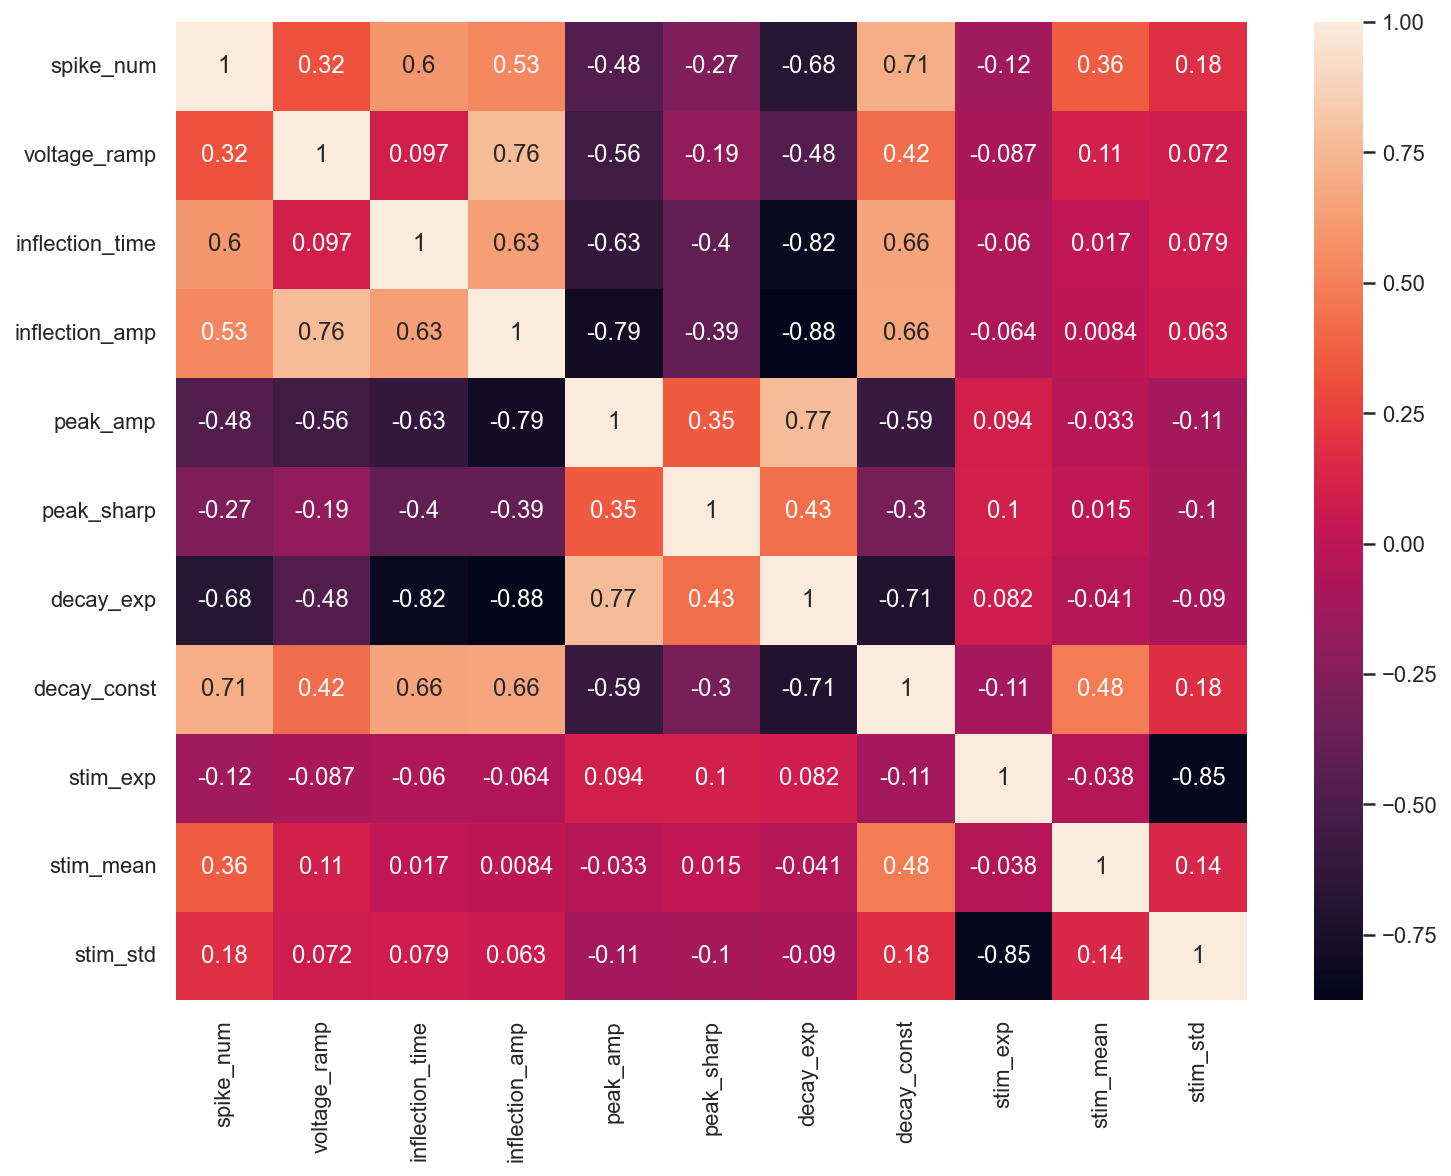

,spike_num,voltage_ramp,inflection_time,inflection_amp,peak_amp,peak_sharp,decay_exp,decay_const,stim_exp,stim_mean,stim_std
spike_num,1.0***,0.32***,0.6***,0.53***,-0.48***,-0.27***,-0.68***,0.71***,-0.12*,0.36***,0.18***
voltage_ramp,0.32***,1.0***,0.1*,0.76***,-0.56***,-0.19***,-0.48***,0.42***,-0.09,0.11*,0.07
inflection_time,0.6***,0.1*,1.0***,0.63***,-0.63***,-0.4***,-0.82***,0.66***,-0.06,0.02,0.08
inflection_amp,0.53***,0.76***,0.63***,1.0***,-0.79***,-0.39***,-0.88***,0.66***,-0.06,0.01,0.06
peak_amp,-0.48***,-0.56***,-0.63***,-0.79***,1.0***,0.35***,0.77***,-0.59***,0.09,-0.03,-0.11*
peak_sharp,-0.27***,-0.19***,-0.4***,-0.39***,0.35***,1.0***,0.43***,-0.3***,0.1*,0.02,-0.1*
decay_exp,-0.68***,-0.48***,-0.82***,-0.88***,0.77***,0.43***,1.0***,-0.71***,0.08,-0.04,-0.09
decay_const,0.71***,0.42***,0.66***,0.66***,-0.59***,-0.3***,-0.71***,1.0***,-0.11*,0.48***,0.18***
stim_exp,-0.12*,-0.09,-0.06,-0.06,0.09,0.1*,0.08,-0.11*,1.0***,-0.04,-0.85***
stim_mean,0.36***,0.11*,0.02,0.01,-0.03,0.02,-0.04,0.48***,-0.04,1.0***,0.14**


In [10]:
df_pink = df.loc[df['stim_type'] == 'pink']
df_pink = df_pink.drop(['sweep', 'stim_type'], axis=1)

pd.plotting.scatter_matrix(df_pink, alpha=0.5)
plt.show()

spikes_corr = df_pink.corr()
# plot the heatmap and annotation on it
sns.heatmap(spikes_corr, xticklabels=spikes_corr.columns, yticklabels=spikes_corr.columns, annot=True)
plt.show()

rho = df_pink.corr()
pval = df_pink.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.01,0.05] if x<=t]))
rho.round(2).astype(str) + p

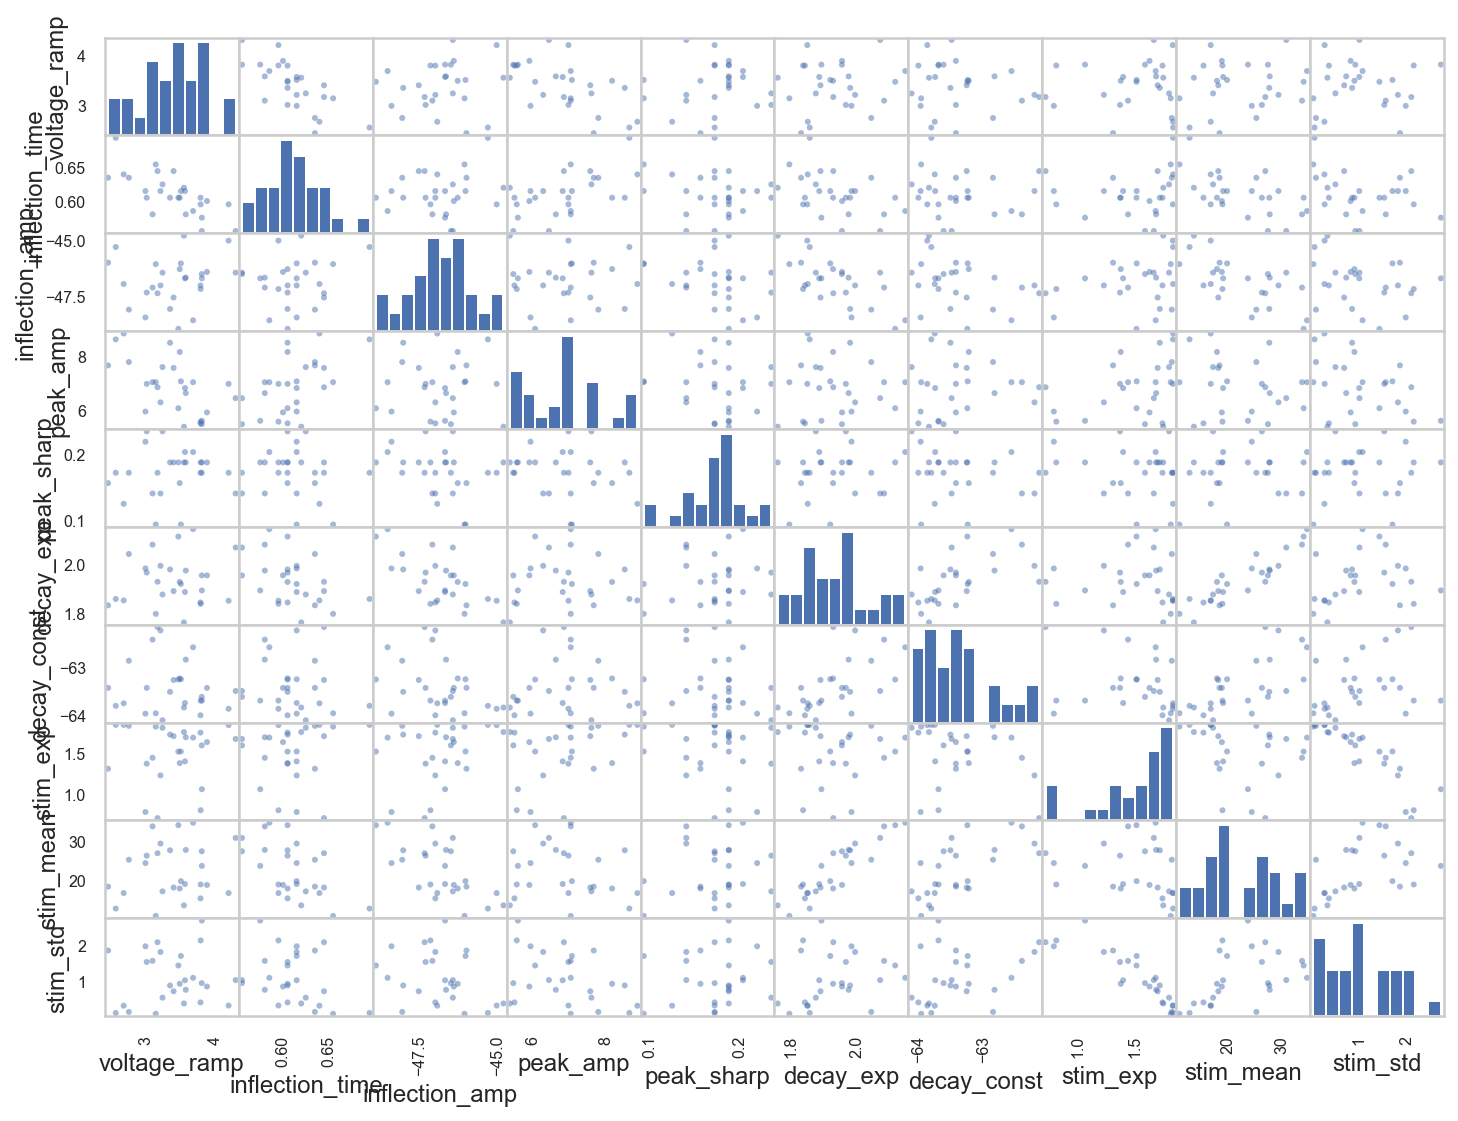

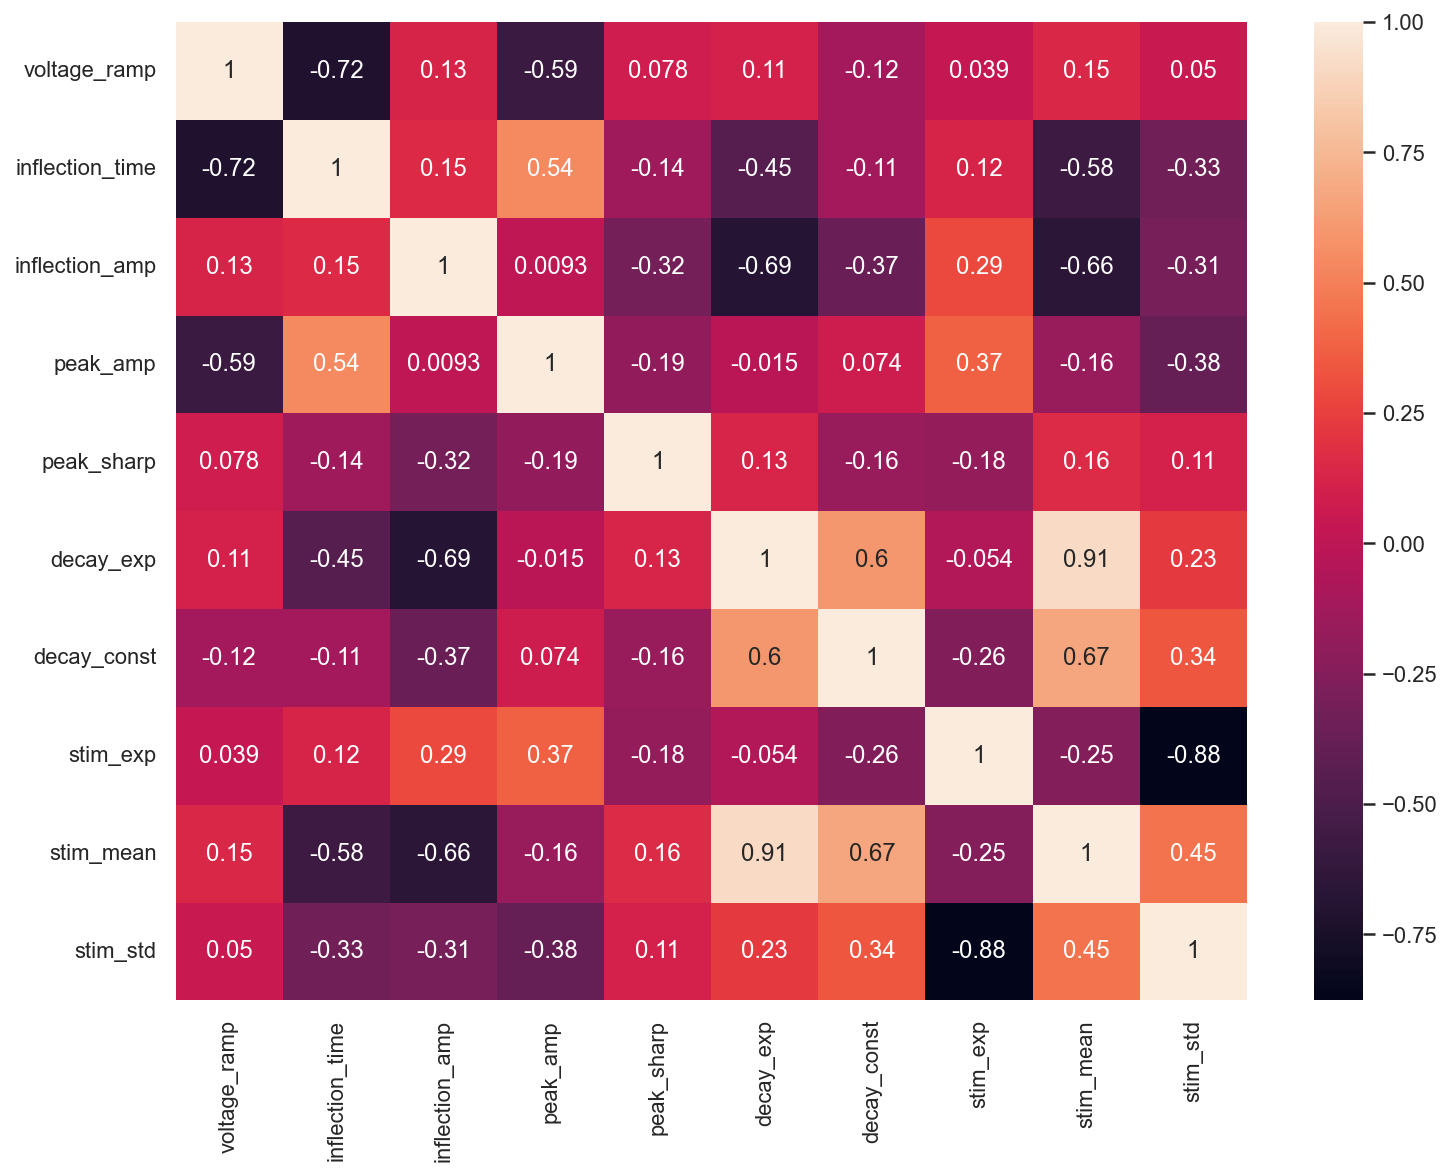

,voltage_ramp,inflection_time,inflection_amp,peak_amp,peak_sharp,decay_exp,decay_const,stim_exp,stim_mean,stim_std
voltage_ramp,1.0***,-0.72***,0.13,-0.59**,0.08,0.11,-0.12,0.04,0.15,0.05
inflection_time,-0.72***,1.0***,0.15,0.54**,-0.14,-0.45*,-0.11,0.12,-0.58**,-0.33
inflection_amp,0.13,0.15,1.0***,0.01,-0.32,-0.69***,-0.37,0.29,-0.66***,-0.31
peak_amp,-0.59**,0.54**,0.01,1.0***,-0.19,-0.01,0.07,0.37,-0.16,-0.38*
peak_sharp,0.08,-0.14,-0.32,-0.19,1.0***,0.13,-0.16,-0.18,0.16,0.11
decay_exp,0.11,-0.45*,-0.69***,-0.01,0.13,1.0***,0.6***,-0.05,0.91***,0.23
decay_const,-0.12,-0.11,-0.37,0.07,-0.16,0.6***,1.0***,-0.26,0.67***,0.34
stim_exp,0.04,0.12,0.29,0.37,-0.18,-0.05,-0.26,1.0***,-0.25,-0.88***
stim_mean,0.15,-0.58**,-0.66***,-0.16,0.16,0.91***,0.67***,-0.25,1.0***,0.45*
stim_std,0.05,-0.33,-0.31,-0.38*,0.11,0.23,0.34,-0.88***,0.45*,1.0***


In [11]:
df_pink_first = df.loc[df['stim_type'] == 'pink']
df_pink_first = df_pink_first.loc[df['spike_num'] == 0]
df_pink_first = df_pink_first.drop(['sweep', 'stim_type', 'spike_num'], axis=1)

pd.plotting.scatter_matrix(df_pink_first, alpha=0.5)
plt.show()

spikes_corr = df_pink_first.corr()
# plot the heatmap and annotation on it
sns.heatmap(spikes_corr, xticklabels=spikes_corr.columns, yticklabels=spikes_corr.columns, annot=True)
plt.show()

rho = df_pink_first.corr()
pval = df_pink_first.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.01,0.05] if x<=t]))
rho.round(2).astype(str) + p